In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved. 
# Licensed under the MIT License

import os
import numpy as np
import pandas as pd
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten, LeakyReLU, Conv2D, MaxPooling2D, ZeroPadding2D, Conv2DTranspose, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import initializers
from privacygan import privacy_gan as pg
from privacygan.cifar import cifar_gan
import warnings

print(tf.__version__)

2.3.0


In [2]:
# Load CIFAR-10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_all = np.concatenate((X_train,X_test))

(n, d1, d2, d3) = X_all.shape

if d3 !=3:
    X_all = np.moveaxis(X_all, 1, 3)
    
X_all = np.float32(X_all)
X_all = (X_all / 255 - 0.5) * 2
X_all = np.clip(X_all, -1, 1)

#Generate training test split
frac = 0.1 
n = int(frac*len(X_all))
l = np.array(range(len(X_all)))
l = np.random.choice(l,len(l),replace = False)
X = X_all[l[:n]]
X_comp = X_all[l[n:]]

print(X.shape)
print(X_comp.shape)

(6000, 32, 32, 3)
(54000, 32, 32, 3)


In [3]:
#Specify models 
generator = cifar_gan.CIFAR_Generator()
discriminator = cifar_gan.CIFAR_Discriminator()
generators = [cifar_gan.CIFAR_Generator(),cifar_gan.CIFAR_Generator()]
discriminators = [cifar_gan.CIFAR_Discriminator(),cifar_gan.CIFAR_Discriminator()]
pDisc = cifar_gan.CIFAR_DiscriminatorPrivate(OutSize = 2)

In [5]:
(generator, discriminator, dLosses, gLosses) = pg.SimpGAN(X, epochs = 1, 
                                                          generator = generator, 
                                                          discriminator = discriminator,
                                                          batchSize=256)

Epochs: 1
Batch size: 256
Batches per epoch: 23.4375
epoch = 1/1, d_loss=0.321, g_loss=2.639                                                                                                                    


In [6]:
#perform white box attack
Acc = pg.WBattack(X,X_comp, discriminator)

White-box attack accuracy: 0.10133333333333333


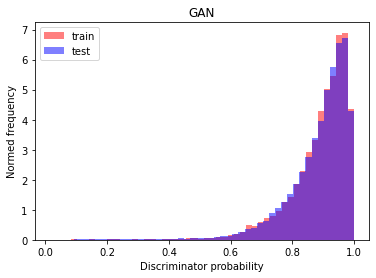

In [7]:
#plot distribution of discriminator scores of training and test set
plt.hist(discriminator.predict(X)[:,0],color = 'r', alpha = 0.5, label = 'train', density = True, bins = 50)
plt.hist(discriminator.predict(X_comp)[:,0],color = 'b', alpha = 0.5, label = 'test', density = True, bins = 50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('GAN')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

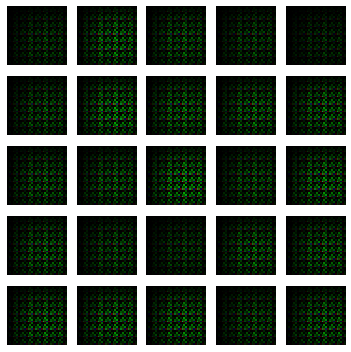

In [8]:
noise = np.random.normal(0, 1, size=[X.shape[0], 100])
generatedImages = generator.predict(noise)
temp = generatedImages[:25].reshape(25, 32, 32, 3)
plt.figure(figsize=(5, 5))
for i in range(temp.shape[0]):
    plt.subplot(5,5, i+1)
    plt.imshow(temp[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()

In [ ]:
tf.keras.backend.clear_session()
optim = Adam(lr=0.0002, beta_1=0.5)
generator = cifar_gan.CIFAR_Generator(optim = Adam(lr=0.0002, beta_1=0.5))
discriminator = cifar_gan.CIFAR_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5))
generators = [cifar_gan.CIFAR_Generator(optim = Adam(lr=0.0002, beta_1=0.5)),
              cifar_gan.CIFAR_Generator(optim = Adam(lr=0.0002, beta_1=0.5))]
discriminators = [cifar_gan.CIFAR_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5)),
                  cifar_gan.CIFAR_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5))]
pDisc = cifar_gan.CIFAR_DiscriminatorPrivate(OutSize = 2,
                                     optim = Adam(lr=0.0002, beta_1=0.5))
(generators, discriminators, _, dLosses, dpLosses, gLosses)= pg.privGAN(X, epochs = 1,
                                                                           disc_epochs=1,
                                                                           generators = generators, 
                                                                           discriminators = discriminators,
                                                                           pDisc = pDisc,
                                                                           optim = optim,
                                                                           privacy_ratio=1.0,
                                                                           batchSize=256)

In [12]:
#perform white box attack
pg.WBattack_priv(X,X_comp, discriminators)

White-box attack accuracy (max): 0.10266666666666667
White-box attack accuracy (mean): 0.1035


(0.10266666666666667, 0.1035)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

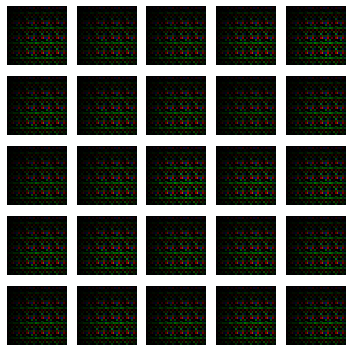

In [11]:
noise = np.random.normal(0, 1, size=[X.shape[0], 100])
generatedImages = generators[0].predict(noise)
temp = generatedImages[:25].reshape(25, 32, 32, 3)
plt.figure(figsize=(5, 5))
for i in range(temp.shape[0]):
    plt.subplot(5,5, i+1)
    plt.imshow(temp[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()

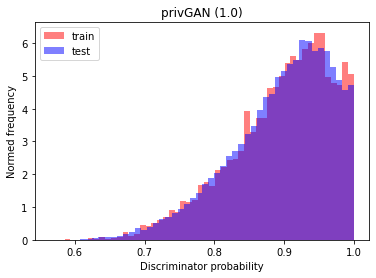

In [13]:
plt.hist(discriminators[0].predict(X)[:,0],color = 'r', alpha = 0.5, label = 'train', density = True, bins = 50)
plt.hist(discriminators[0].predict(X_comp)[:,0],color = 'b', alpha = 0.5, label = 'test', density = True, bins = 50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('privGAN (1.0)')
plt.legend()

In [14]:
pg.WBattack_priv(X,X_comp, discriminators)

White-box attack accuracy (max): 0.10266666666666667
White-box attack accuracy (mean): 0.1035


(0.10266666666666667, 0.1035)